### Ejemplo de dataframe para gráfica de multilineas

In [7]:
import pandas as pd
import numpy as np

# Generar datos
fechas = pd.date_range(start="2000-01-01", end="2025-12-31", freq="YE")
n = len(fechas)

# Generar valores aleatorios que suben con el tiempo y caen bruscamente al final
valores = {
    "Fecha": fechas,
    "Columna1": np.concatenate([
        np.sort(np.random.uniform(100, 4000, n - 5)),  # Valores ascendentes aleatorios
        np.random.uniform(500, 1000, 5)  # Caída brusca al final
    ]),
    "Columna2": np.concatenate([
        np.sort(np.random.uniform(200, 3500, n - 5)),
        np.random.uniform(300, 800, 5)
    ]),
    "Columna3": np.concatenate([
        np.sort(np.random.uniform(300, 3000, n - 5)),
        np.random.uniform(100, 600, 5)
    ]),
    "Columna4": np.concatenate([
        np.sort(np.random.uniform(400, 2500, n - 5)),
        np.random.uniform(50, 500, 5)
    ]),
}

# Crear DataFrame
df = pd.DataFrame(valores)

# Transformar el DataFrame a formato long
df_long = pd.melt(
    df,
    id_vars=["Fecha"],
    value_vars=["Columna1", "Columna2", "Columna3", "Columna4"],
    var_name="Variable",
    value_name="Valor"
)

df_long

,Fecha,Variable,Valor
0,2000-12-31,Columna1,218.965725
1,2001-12-31,Columna1,427.543208
2,2002-12-31,Columna1,645.882724
3,2003-12-31,Columna1,658.252988
4,2004-12-31,Columna1,706.151575
...,...,...,...
99,2021-12-31,Columna4,293.714061
100,2022-12-31,Columna4,98.797254
101,2023-12-31,Columna4,368.976150
102,2024-12-31,Columna4,440.893189


### **Código a copiar para gráfica de multilineas:**

In [8]:
import subprocess

def limpiar_svg_con_scour(archivo_entrada, archivo_salida):
    subprocess.run([
        'scour', '-i', archivo_entrada, '-o', archivo_salida,
        '--enable-viewboxing', '--enable-id-stripping',
        '--shorten-ids', '--remove-descriptive-elements'
    ], check=True)

def limpiar_svg_con_svgo(archivo_entrada, archivo_salida):
    subprocess.run(['svgo', archivo_entrada, '-o', archivo_salida], check=True)

Scour processed file "multilineal.svg" in 53 ms: 36262/63956 bytes new/orig -> 56.7%

multilineal_scour.svg:
Done in 61 ms!
35.412 KiB - 23.7% = 27.029 KiB


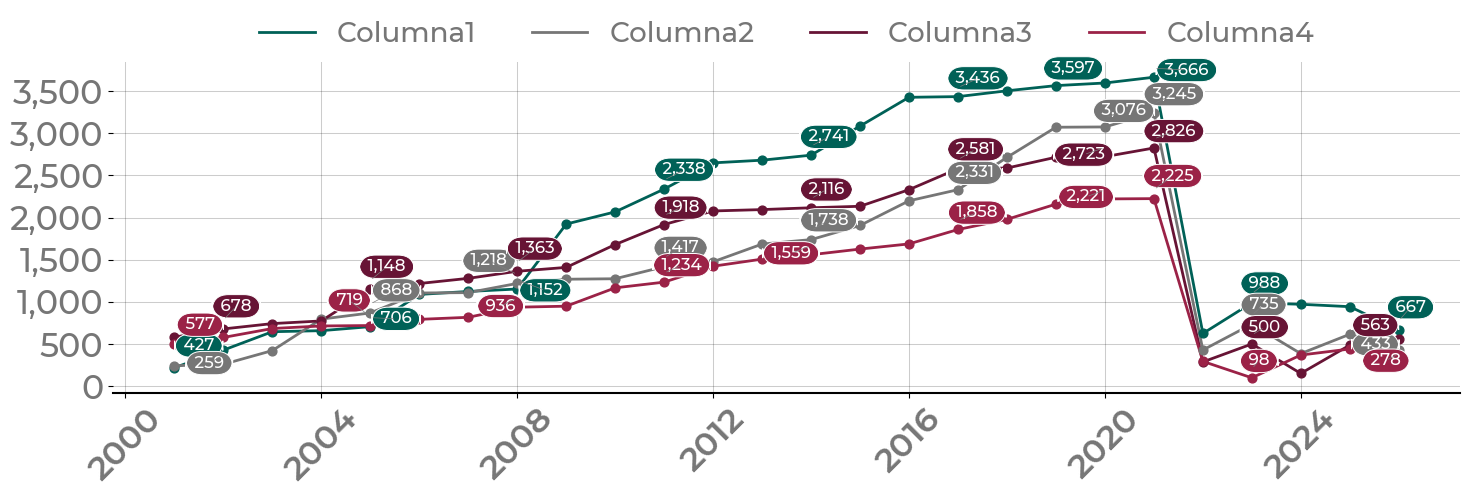

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as font_manager

def ajusta_etiquetas(
    dataframe, 
    columnas, 
    colores, 
    columna_x, 
    sin_tag=2, 
    max=True, 
    fontsize=16, 
    fontname=None,
    fontweight=None,
    fontcolor=None,
    escala=None
):
    """
    Devuelve la lista de textos a etiquetar, pero NO llama a adjust_text.
    """
    texts = []
    for col, color in zip(columnas, colores):
        total_puntos = len(dataframe)
        max_index = dataframe[col].idxmax() if max else None
        for i, row in dataframe.iterrows():
            tiene_etiqueta = (total_puntos - i - 1) % (sin_tag + 1) == 0 or i == total_puntos - 1 or (max and i == max_index)
            if tiene_etiqueta:
                bbox_props = dict(boxstyle="round,pad=0.25,rounding_size=0.99", fc=color, ec="none", alpha=1.0)
                espacio = "\u00A0"
                va = 'bottom' if i % 2 == 0 else 'top'
                offset = escala if va == 'bottom' else -escala
                texts.append(
                    plt.text(
                        row[columna_x], 
                        row[col] + offset,
                        f"{espacio*1}{int(row[col]):,}{espacio*1}",
                        fontsize=fontsize, 
                        color=fontcolor if fontcolor else "white",
                        weight=fontweight,
                        ha='center', 
                        va=va, 
                        bbox=bbox_props,
                        fontname=fontname
                    )
                )
    return texts


def multilineal(
    df_long, 
    nombre=None,
    font='Arial',
    columna_fecha="Fecha", 
    columna_variable="Variable", 
    columna_valor="Valor", 
    tipografia=None,
    margen=0.7,
):
    from pathlib import Path
    from adjustText import adjust_text
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import matplotlib.font_manager as font_manager

    font_config = {
        'family': font,
        'variable_x': {'size': 24, 'weight': 'semibold', 'color': '#767676'},
        'variable_y': {'size': 24, 'weight': 'medium', 'color': '#767676'},
        'capsula_valor': {'size': 12, 'weight': 'medium', 'color': '#ffffff'},
        'leyenda': {'size': 20, 'weight': 'medium', 'color': '#767676'}
    }

    plt.rcParams['svg.fonttype'] = 'none'
    font_dirs = [Path("../0_fonts")]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)

    ancho_px = 1480
    alto_px = 520
    dpi = 100
    ancho_in = ancho_px / dpi
    alto_in = alto_px / dpi

    fig, ax = plt.subplots(figsize=(ancho_in, alto_in), dpi=dpi)

    colores_asignados = ["#006157", "#767676", "#671435", "#9B2247", "#9D792A", "#D5B162"]
    variables = df_long[columna_variable].unique()
    color_map = {var: colores_asignados[i % len(colores_asignados)] for i, var in enumerate(variables)}

    # Graficar todas las líneas y puntos primero
    for i, var in enumerate(variables):
        datos = df_long[df_long[columna_variable] == var]
        ax.plot(
            datos[columna_fecha],
            datos[columna_valor],
            label=var,
            color=color_map[var],
            linewidth=2
        )
        ax.scatter(
            datos[columna_fecha],
            datos[columna_valor],
            color=color_map[var],
            s=40,
            zorder=3
        )

    # Calcular la escala global para el offset de etiquetas
    escala = df_long[columna_valor].max() - df_long[columna_valor].min()

    # Ahora agregar las etiquetas en un ciclo aparte
    all_texts = []
    sin_tag = 2  # Puedes ajustar este parámetro según lo que desees
    for i, var in enumerate(variables):
        datos = df_long[df_long[columna_variable] == var].reset_index(drop=True)
        total_puntos = len(datos)
        max_index = datos[columna_valor].idxmax()
        color = color_map[var]
        for j, row in datos.iterrows():
            tiene_etiqueta = (total_puntos - j - 1) % (sin_tag + 1) == 0 or j == total_puntos - 1 or j == max_index
            if tiene_etiqueta:
                bbox_props = dict(
                    boxstyle="round,pad=0.25,rounding_size=0.99", 
                    fc=color,
                    ec='#ffffff', 
                    lw=margen, 
                    alpha=1.0
                )
                espacio = "\u00A0"
                va = 'bottom'
                offset = abs(escala) * 0.03 if escala else 10
                all_texts.append(
                    plt.text(
                        row[columna_fecha],
                        row[columna_valor] + offset,
                        f"{espacio*1}{int(row[columna_valor]):,}{espacio*1}",
                        fontsize=font_config['capsula_valor']['size'],
                        color=font_config['capsula_valor']['color'],
                        weight=font_config['capsula_valor']['weight'],
                        ha='center',
                        va=va,
                        bbox=bbox_props,
                        fontname=font_config['family']
                    )
                )

    # Ajusta todas las etiquetas juntas
    adjust_text(
        all_texts,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        force_text=(150, 150),
        expand_points=(150, 150),
        expand_text=(150, 150),
        only_move={'points': 'y', 'text': 'y'},
        autoalign='y',
        lim=1000,
    )

    # Etiquetas y formato
    plt.xticks(
        rotation=45,
        fontsize=font_config['variable_x']['size'],
        weight=font_config['variable_x']['weight'],
        color=font_config['variable_x']['color'],
        fontname=font_config['family']  
    )
    plt.yticks(
        fontsize=font_config['variable_y']['size'],
        weight=font_config['variable_y']['weight'],
        color=font_config['variable_y']['color'],
        fontname=font_config['family'] 
    )
    leg = ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.2),
        ncol=len(variables),
        frameon=False,
        prop={
            'size': font_config['leyenda']['size'],
            'weight': font_config['leyenda']['weight'],
            'family': font_config['family']
        }
    )
    # Aplicar color manualmente a los textos de la leyenda
    for text in leg.get_texts():
        text.set_color(font_config['leyenda']['color'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.grid(axis='y', linestyle='-', color='#000000', alpha=0.2, linewidth=0.75)
    ax.grid(axis='x', linestyle='-', color='#000000', alpha=0.2, linewidth=0.75)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    #ax.spines['bottom'].set_position(('data', 0))  

    nombre_df = nombre or "multilineal"
    plt.tight_layout()
    plt.savefig(f"{nombre_df}.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.savefig(f"{nombre_df}.png", format='png', bbox_inches='tight', dpi=300)
    nombre_svg = f"{nombre_df}.svg"
    nombre_svg_limpio = f"{nombre_df}_scour.svg"
    nombre_svg_svgo = f"{nombre_df}_svgo.svg"

    try:
        limpiar_svg_con_scour(nombre_svg, nombre_svg_limpio)
    except Exception as e:
        print("Error al limpiar con Scour:", e)

    try:
        limpiar_svg_con_svgo(nombre_svg_limpio, nombre_svg_svgo)
    except Exception as e:
        print("Error al limpiar con SVGO:", e)

    plt.show()

multilineal(df_long, font='Montserrat', nombre='multilineal', columna_fecha="Fecha")